# Radar download and quicklook
### from top of our list of tornado events 
#### (wide, close to radar)

In [1]:
import pandas as pd
import numpy as np 
import os
import datetime
import nexradaws
import pyart 
import matplotlib.pyplot as plt

# suppress pink warning boxes (annoying) 
import warnings
warnings.filterwarnings('ignore')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


In [2]:
filename = '~/Box/MPO624_data/1991-2019_tornadoes_tornadoes.wid>500_byRadarDistances.csv'
wid500 = pd.read_csv(filename)
wid500

,Unnamed: 0,yr,mo,dy,date,time,st,mag,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,NearestRadar,NearestDist
0,0,2015,5,16,5/16/15,22:43:00,OK,2,0,0,1.00,0.0,36.1719,-95.5700,36.2872,-95.4681,9.80,1500,KINX,0.624151
1,1,2019,4,13,4/13/19,22:22:00,MS,2,0,0,500000.00,0.0,33.8931,-88.3215,34.0831,-88.2901,13.20,800,KGWX,0.834936
2,2,2018,4,13,4/13/18,23:10:00,LA,1,0,1,7000000.00,0.0,32.4521,-93.8531,32.6070,-93.5129,22.54,1100,KSHV,1.117873
3,3,2008,4,3,4/3/08,21:06:00,AR,2,0,0,12.00,0.0,34.8100,-92.2700,34.8900,-92.1900,7.07,800,KLZK,3.032709
4,4,2003,4,24,4/24/03,20:53:00,MS,3,6,0,50.00,0.0,32.2500,-90.0000,32.3500,-89.8500,12.00,600,KDGX,3.605939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1518,1518,2015,5,25,5/25/15,13:42:00,OK,3,1,1,0.00,0.0,33.9830,-96.2684,34.2308,-96.1856,18.80,700,KSRX,227.969035
1519,1519,2011,4,21,4/21/11,17:45:00,TX,2,0,0,0.10,0.0,30.2045,-102.4450,30.1582,-102.3250,7.82,800,KDFX,232.240088
1520,1520,2010,6,17,6/17/10,15:59:00,MN,4,20,0,0.00,0.0,46.4100,-95.1800,46.5216,-95.0260,10.00,1936,KDLH,232.538443
1521,1521,2005,6,6,6/6/05,16:00:00,TX,1,0,0,0.28,0.0,31.4800,-95.4700,31.4800,-95.4700,6.00,850,KPOE,239.073260


# Can we automatically plot a horizontal sweep from the case start time?

The resource:
https://registry.opendata.aws/noaa-nexrad/

A pip package:
https://pypi.org/project/nexradaws/

A notebook that gets a directory listing, but just takes a convenient one
https://github.com/openradar/AMS_radar_in_the_cloud/blob/master/notebooks/introduction%20to%20S3%2C%20Boto%20and%20Nexrad%20on%20S3%20with%20a%20hurricane%20chaser.ipynb 

Something about wildcard-like tools in AWS
https://docs.aws.amazon.com/cli/latest/reference/s3/#use-of-exclude-and-include-filters

Oh bingo, 
https://github.com/openradar/AMS-Open-Source-Radar-2019/blob/master/pyart/3_Pangeo_only_Simple_NEXRAD.ipynb

So much stuff 
https://openradarscience.org/projects/

## To download and plot radar sweeps off Amazon/AWS, 
   * need some environment packages:
   
`conda create -n tropycal -c conda-forge  matplotlib numpy scipy pandas geopy cartopy xarray netCDF4 networkx requests jupyterlab tropycal metpy boto3 botocore boto` and then 
`conda clean —all` frees up disk space from zipped files that went into the environment. From inside the environment, I did `pip install arm_pyart` for the pyart package and `pip install nexradaws` for file access utilities. 

---------------

--------
# Ready to loop (start with icase=1)

In [3]:
icase = 1 # First item in sorted list; later can be index variable in a loop over cases 

# Extract radar station ID
station = wid500['NearestRadar'][icase]

# Where to download the data into: our Box 
data_dir = os.path.expanduser('~/Box/MapesGroupUndergradResearch/NEXRAD_FILES')

# Connect to Amazon
conn = nexradaws.NexradAwsInterface()

# List all scans within 1 hour of the case hour 
# conn.get_avail_scans_in_range(start, end, radar)

d = datetime.datetime(wid500['yr'][icase], wid500['mo'][icase], wid500['dy'][icase], int(wid500['time'][icase][0:2]))
d2 = d + datetime.timedelta(hours=1)
scans = conn.get_avail_scans_in_range(d, d2, wid500['NearestRadar'][icase])

# next to last sweep in the hour [-2]
# must avoid filenames not ending in _V06
# so more code needed here, but this works for icase=1

print(scans[-2].filename, ' downloading to ')

localfiles = conn.download(scans[-2],data_dir)
print(localfiles.success[0].filepath)

KGWX20190413_225734_V06  downloading to 
Downloaded KGWX20190413_225734_V06
1 out of 1 files downloaded...0 errors
/Users/bem/Box/MapesGroupUndergradResearch/NEXRAD_FILES/KGWX20190413_225734_V06


# Displays, working off the downloaded data file
### do we want this inside a loop over cases, or outside? 
user chooses, for now it works from the first successfully gotten file of the previous download request 

In [4]:
radar = pyart.io.read(localfiles.success[0].filepath)

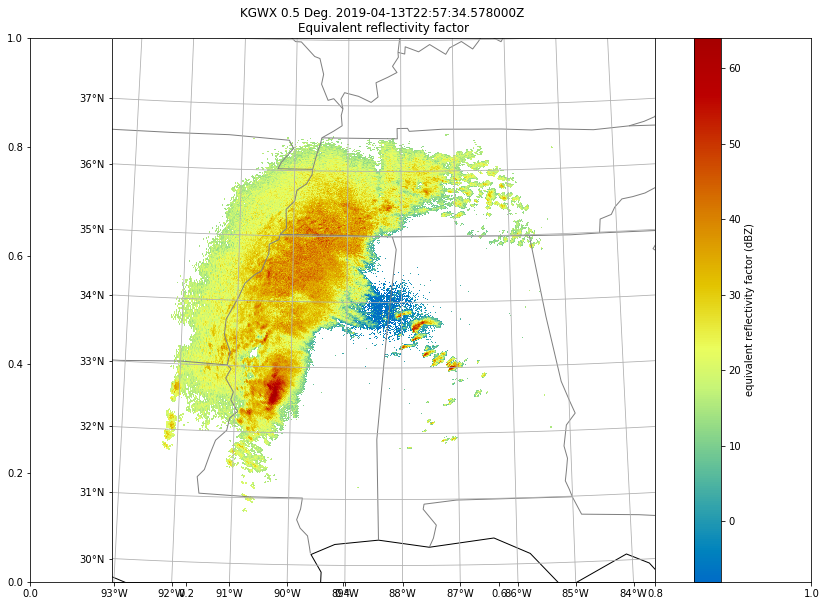

In [5]:
myf = plt.figure(figsize=[14,10])
myd = pyart.graph.RadarMapDisplay(radar)
myd.plot_ppi_map('reflectivity', 0, vmin=-8, vmax=64)

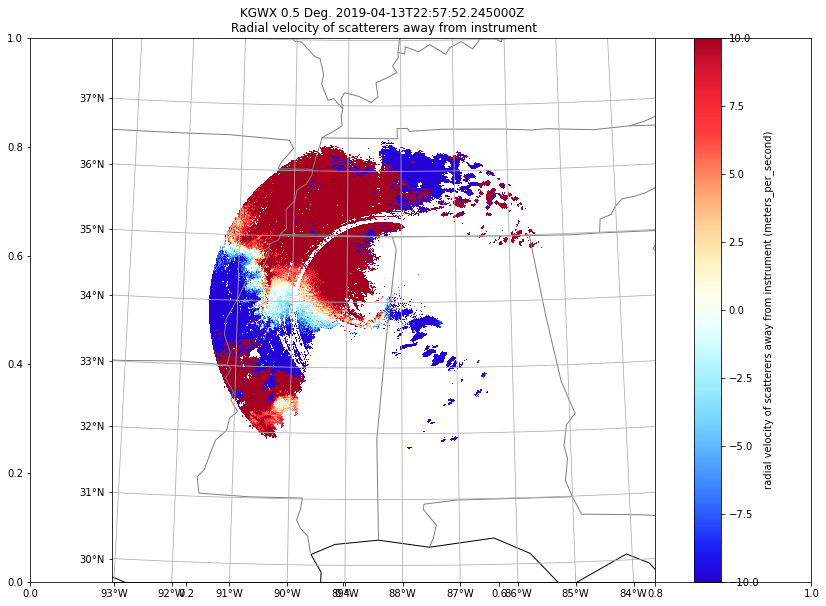

In [6]:
myf = plt.figure(figsize=[14,10])
myd = pyart.graph.RadarMapDisplay(radar)
myd.plot_ppi_map('velocity', 1, vmin=-10, vmax=10)

# Nice quicklook. What are the options? 

In [7]:
myd.plot_ppi_map?

Signature:
myd.plot_ppi_map(
    field,
    sweep=0,
    mask_tuple=None,
    vmin=None,
    vmax=None,
    cmap=None,
    norm=None,
    mask_outside=False,
    title=None,
    title_flag=True,
    colorbar_flag=True,
    colorbar_label=None,
    ax=None,
    fig=None,
    lat_lines=None,
    lon_lines=None,
    projection=None,
    min_lon=None,
    max_lon=None,
    min_lat=None,
    max_lat=None,
    width=None,
    height=None,
    lon_0=None,
    lat_0=None,
    resolution='110m',
    shapefile=None,
    shapefile_kwargs=None,
    edges=True,
    gatefilter=None,
    filter_transitions=True,
    embelish=True,
    raster=False,
    ticks=None,
    ticklabs=None,
    alpha=None,
)
Docstring:
Plot a PPI volume sweep onto a geographic map.

Parameters
----------
field : str
    Field to plot.
sweep : int, optional
    Sweep number to plot.

Other Parameters
----------------
mask_tuple : (str, float)
    Tuple containing the field name and value below which to mask
    field prior to